In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
plt.style.use('fivethirtyeight')

In [39]:
crypto_df = pd.read_csv('train.csv')

In [4]:
crypto_df.shape

(24236806, 10)

In [11]:
crypto_df.head(5)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [40]:
btf = crypto_df[crypto_df["Asset_ID"]==0].set_index("timestamp")
#btf = btf.drop(columns=['timestamp'])

In [41]:
btf.index = pd.to_datetime(btf.index, unit='s')

In [45]:
btf.tail(5)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-06 23:56:00,0,26.0,22.6318,22.7339,22.6016,22.650,515.42,22.655325,-0.036245
2018-01-06 23:57:00,0,38.0,22.6401,22.8800,22.6400,22.734,1367.55,22.747933,-0.030802
2018-01-06 23:58:00,0,32.0,22.8222,22.8222,22.6800,22.680,1123.60,22.731633,-0.026549
2018-01-06 23:59:00,0,20.0,22.6999,22.6999,22.6000,22.600,1004.55,22.612450,-0.022222
2018-01-07 00:00:00,0,26.0,22.6000,22.6599,22.4995,22.500,4590.06,22.510002,-0.017782


In [44]:
btf = btf.loc[(btf.index > '2018-01-01') & (btf.index <= '2018-01-07')]

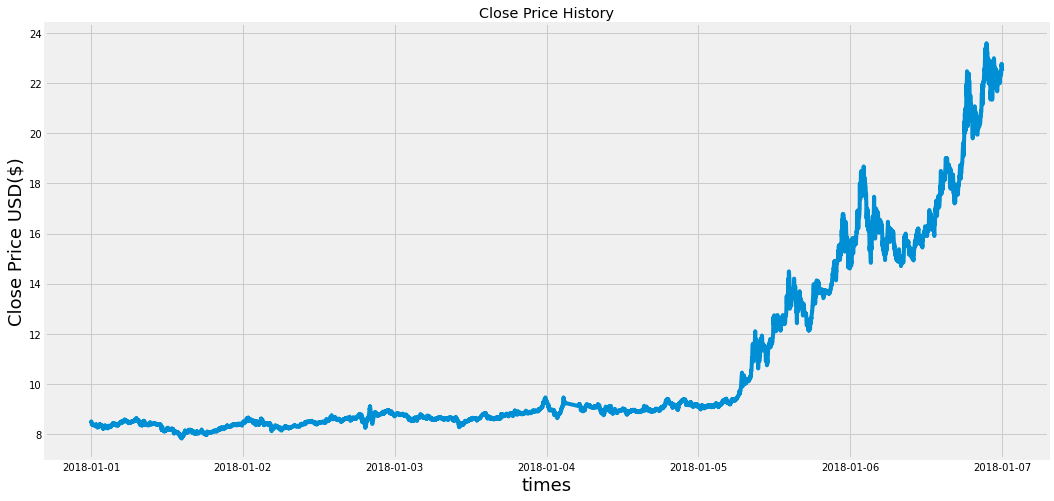

In [70]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(btf['Close'])
plt.xlabel('times', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.show()

In [67]:
# in this case, we use log return to predict our model instead of actual price, 
# this is more visual to capture our ROI
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

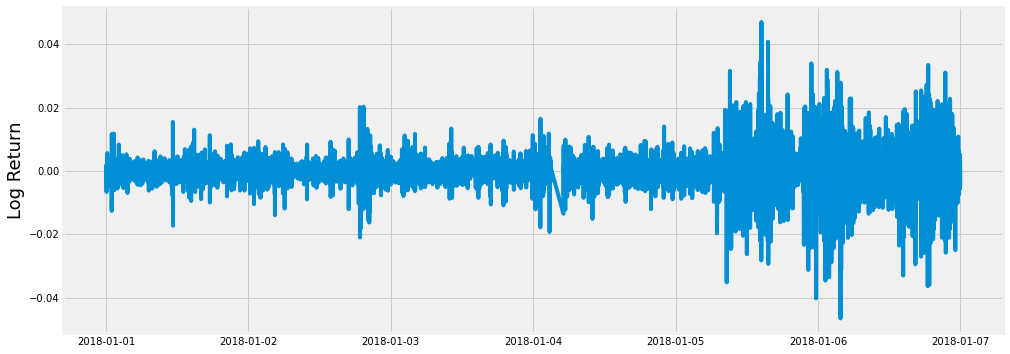

In [71]:
import scipy.stats as stats

lret_btf = log_return(btf['Close'])[1:]

plt.figure(figsize=(15,6))
plt.ylabel('Log Return', fontsize=18)
plt.plot(lret_btf);
plt.show()

# Cross Validation

In [59]:
from sklearn.model_selection import TimeSeriesSplit

In [60]:
tss = TimeSeriesSplit(n_splits=5)

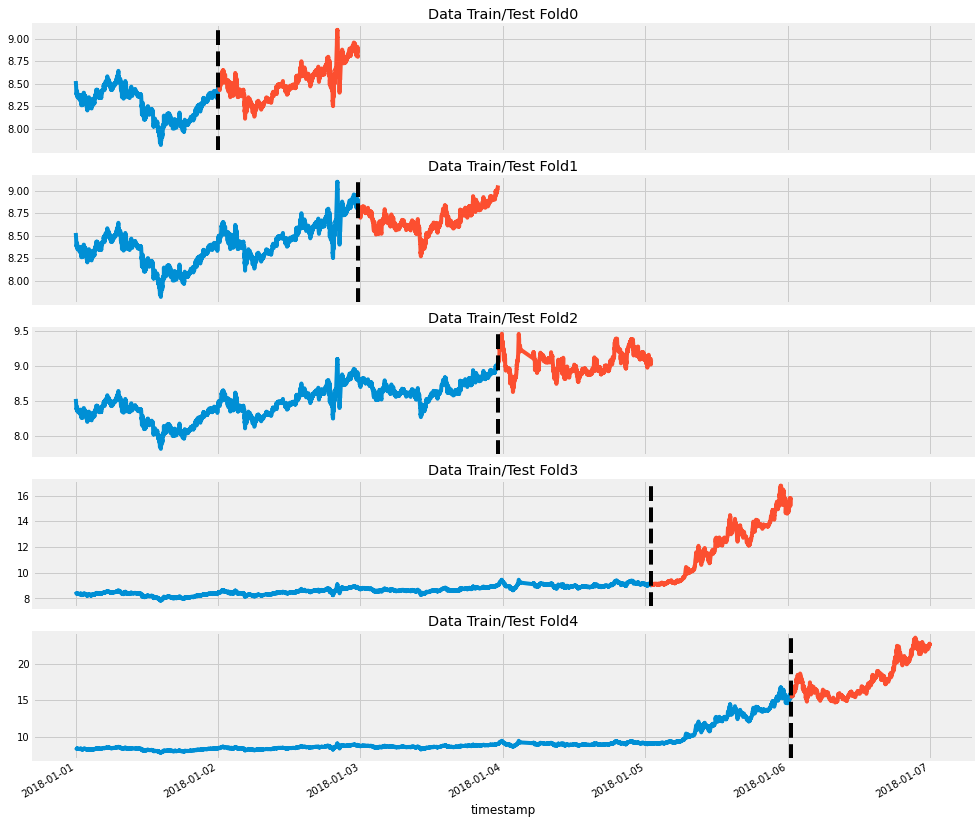

In [63]:
#注意这里做的是train、test split不需要考虑gap，而对于feature和label之间的gap依据比赛规则是15分钟
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, test_idx in tss.split(btf):
    train = btf.iloc[train_idx]
    test = btf.iloc[test_idx]
    train['Close'].plot(ax = axs[fold],
                       label = 'Training set',
                       title = f'Data Train/Test Fold{fold}')
    test['Close'].plot(ax = axs[fold],
                   label = 'Test set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Models

## LSTM

https://www.youtube.com/watch?v=QIUxPv5PJOY

In [31]:
# create a new df with only the close column
data = crypto_df.filter(['Close'])
# convert to numpy array
dataset = data.values
# get the number of rows to train the model on
train_data_len = math.ceil(len(dataset) * .8)
train_data_len

1040

In [32]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.91538178],
       [0.89438276],
       [0.86889931],
       ...,
       [0.67464174],
       [0.65961689],
       [0.68567303]])

In [73]:
train_data = train_data[0:train_data_len, :]
# test_data = scaled_data[train_data_len-60:, :], we need -60 to get the values for predicting front rows in test set
# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0]) 

KeyError: 'key of type tuple not found and not a MultiIndex'

In [36]:
#convert the x_train and y_train to np array
x_train, y_train = np.array(x_train), np.array(y_train)

In [39]:
# reshape the date, LSTM expects the data to be 3-dimensional, number of sample, number of time steps, number of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(980, 60, 1)

In [41]:
# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [42]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
# train the mode
model.fit(x_train, y_train, batch_size=1, epochs=1)

980/980 [==============================] - 12s 10ms/step - loss: 0.0043


In [44]:
# create the testing dataset
# create a new array containing scaled values from index 980 to 1040
test_data = scaled_data[train_data_len-60:, :]
x_test = []
y_test = dataset[train_data_len:, :] # not scaled but normal values in dataset
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [45]:
# convert to np and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [46]:
# prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

9/9 [==============================] - 1s 7ms/step


In [47]:
# evaluate, get the RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

4.494929880615375

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


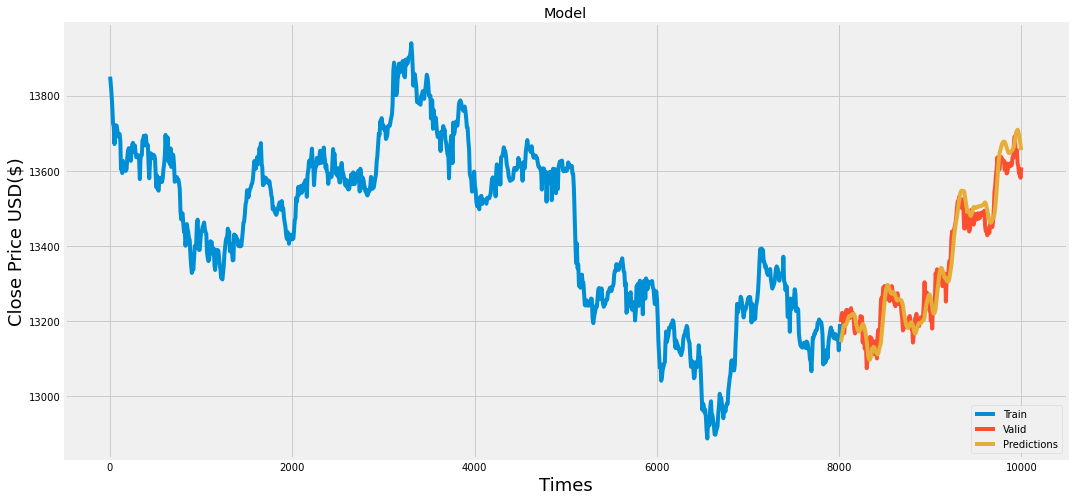

In [48]:
# plot
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predections'] = predictions
# visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Times', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predections']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

## XGBoost

https://www.youtube.com/watch?v=vV12dGe_Fho

In [6]:
def get_features(data):
    # FE for data as row of DataFrame
    
    # Two new features from the competition tutorial
    df_feat = data.copy()
    df_feat['Upper_Shadow'] = df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open'])
    df_feat['Lower_Shadow'] = np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low']
    
    # Thanks to https://www.kaggle.com/code1110/gresearch-simple-lgb-starter
    df_feat['lower_shadow'] = np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low']
    df_feat['high2low'] = df_feat['High'] / df_feat['Low']
    df_feat['volume2count'] = df_feat['Volume'] / (df_feat['Count'] + 1)
    
    return df_feat

In [7]:
crypto_df = get_features(crypto_df)

In [ ]:
def get_data_for_asset(df_train, asset_id):
    # Get X and y
    
    df = df_train[df_train["Asset_ID"] == asset_id]    
    df_proc = get_features(df)
    df_proc['y'] = df['Target']
    #df_proc = df_proc[~df_proc.isin([np.nan, np.inf, -np.inf]).any(1)].reset_index(drop=True)
    df_proc = df_proc.dropna(how="any")
    
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]
    scaler = MinMaxScaler()
    training_data = scaler.fit_transform(training_data)
    
    return X, y

## Data features
We can see the different features included in the dataset. Specifically, the features included per asset are the following:
*   **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
*   **Asset_ID**: The asset ID corresponding to one of the crytocurrencies (e.g. `Asset_ID = 1` for Bitcoin). The mapping from `Asset_ID` to crypto asset is contained in `asset_details.csv`.
*   **Count**: Total number of trades in the time interval (last minute).
*   **Open**:	Opening price of the time interval (in USD).
*   **High**:	Highest price reached during time interval (in USD).
*   **Low**: Lowest price reached during time interval (in USD).
*   **Close**:	Closing price of the time interval (in USD).
*   **Volume**:	Quantity of asset bought or sold, displayed in base currency USD.
*   **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
*   **Target**: Residual log-returns for the asset over a 15 minute horizon. 

The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time. The last column is the prediction target, which we will get to later in more detail.

We also view the asset information, including the list of all assets, the `Asset_ID` to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric.

In [ ]:
asset_details = pd.read_csv('/content/drive/MyDrive/competitions/g-research-crypto-forecasting/asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Candlestick charts

The trading data format is an aggregated form of market data including for Open, High, Low and Close. We can visualize this data through the commonly used candlestick bar chart, which allows traders to perform technical analysis on intraday values. The bar's body length represents the price range between the open and close of that day's trading. When the bar is red, it means the close was lower than the open, and green otherwise. These are also referred to as bullish and bearish candlesticks. The wicks above and below the bars show the high and low prices of that interval's trading.

In [8]:
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:] # Select recent data rows

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

# Preprocessing

## Dealing with missing data

Let us inspect the data for another important asset, Ethereum.

In [ ]:
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp") # Asset_ID = 6 for Ethereum
eth.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956200 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Asset_ID  int64  
 1   Count     float64
 2   Open      float64
 3   High      float64
 4   Low       float64
 5   Close     float64
 6   Volume    float64
 7   VWAP      float64
 8   Target    float64
dtypes: float64(8), int64(1)
memory usage: 149.2 MB


In [ ]:
eth.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      340
dtype: int64

Let's check the time range for Bitcoin and Ethereum data, using the coversion from timestamp to `datetime`.

In [ ]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [ ]:
beg_btc = btc.index[0].astype('datetime64[s]')
end_btc = btc.index[-1].astype('datetime64[s]')
beg_eth = eth.index[0].astype('datetime64[s]')
end_eth = eth.index[-1].astype('datetime64[s]')

print('BTC data goes from ', beg_btc, 'to ', end_btc)
print('Ethereum data goes from ', beg_eth, 'to ', end_eth)

BTC data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00
Ethereum data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


Missing asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows. We can check the timestamp difference between consecutive rows to see if there is missing data.

In [ ]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60     1956043
120        100
180         23
300          5
540          4
Name: timestamp, dtype: int64

**DataFrame.reindex(labels=None, index=None, columns=None, axis=None, method=None, copy=True, level=None, fill_value=nan, limit=None, tolerance=None)**

method{None, ‘backfill’/’bfill’, ‘pad’/’ffill’, ‘nearest’}
Method to use for filling holes in reindexed DataFrame. Please note: this is only applicable to DataFrames/Series with a monotonically increasing/decreasing index.

None (default): don’t fill gaps

**pad / ffill: Propagate last valid observation forward to next valid.**

backfill / bfill: Use next valid observation to fill gap.

nearest: Use nearest valid observations to fill gap.

In [ ]:
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

In [ ]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

In [ ]:
(btc.index[1:]-btc.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

In [ ]:
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')

In [ ]:
btc.isna().sum()

timestamp     0
Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target       76
dtype: int64

## Data visualisation

We  will start by visualising the Close prices for the two assets we have selected.

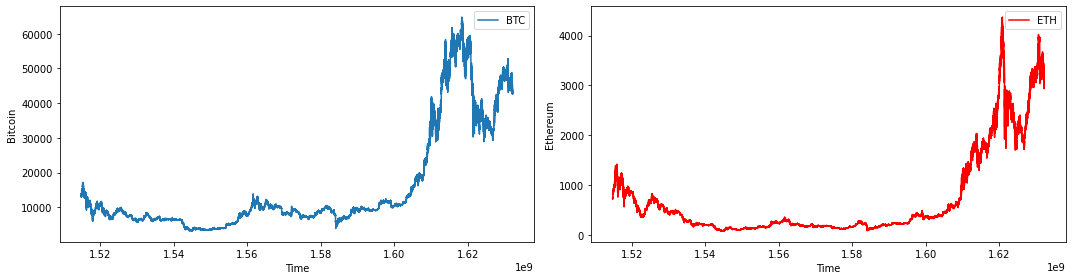

In [ ]:
# plot vwap time series for both chosen assets
f = plt.figure(figsize=(15,4))


ax = f.add_subplot(121)
plt.plot(btc['Close'], label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(122)
ax2.plot(eth['Close'], color='red', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

plt.tight_layout()
plt.show()

The assets have quite different history, but we could check if they correlate in recent times.

In [ ]:
import time

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create intervals
btc_mini_2021 = btc.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]
eth_mini_2021 = eth.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

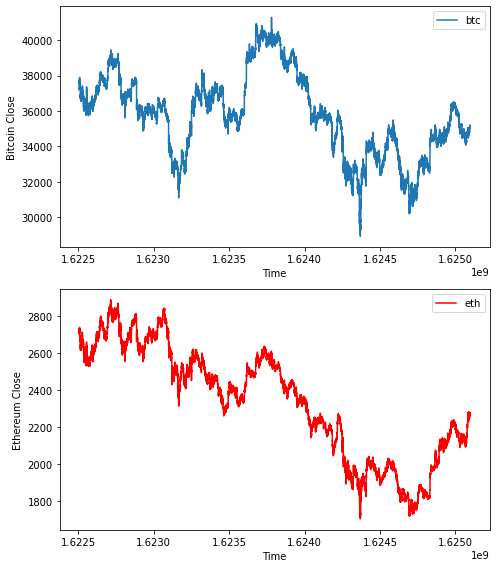

In [ ]:
# plot time series for both chosen assets
f = plt.figure(figsize=(7,8))

ax = f.add_subplot(211) # set the quadrant in which the figure locates
plt.plot(btc_mini_2021['Close'], label='btc')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')

ax2 = f.add_subplot(212)
ax2.plot(eth_mini_2021['Close'], color='red', label='eth')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum Close')

plt.tight_layout()
plt.show()

In [ ]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

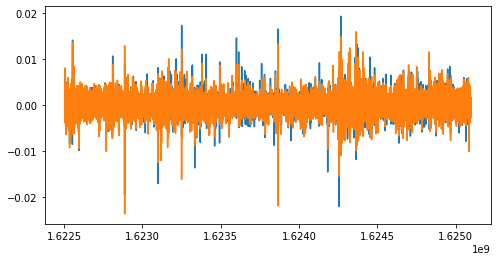

In [ ]:
import scipy.stats as stats

lret_btc = log_return(btc_mini_2021.Close)[1:]
lret_eth = log_return(eth_mini_2021.Close)[1:]
lret_btc.rename('lret_btc', inplace=True)
lret_eth.rename('lret_eth', inplace=True)

plt.figure(figsize=(8,4))
plt.plot(lret_btc);
plt.plot(lret_eth);
plt.show()

Resampling for months or weeks and making bar plots is a another very simple and widely used method of finding seasonality. Here I am making a bar plot of hour data.

In [ ]:
from datetime import datetime
btc = crypto_df[crypto_df["Asset_ID"]==1]
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
btc_copy = btc
btc_copy['timestamp'] = pd.to_datetime(btc_copy['timestamp'], unit='s')

### Bar Plot

Here I am making a bar plot of month data for 2018 to 2021. For the index, I will use [2018:]. Because our dataset contains data until 2021. So, 2018 to end should bring 2018 to 2021.

Each bar represents a month. A huge spike in April 2020. Otherwise, there is no monthly seasonality here.

In [ ]:
import matplotlib.dates as mdates
btc_month = btc_copy.resample("M", on='timestamp').mean()

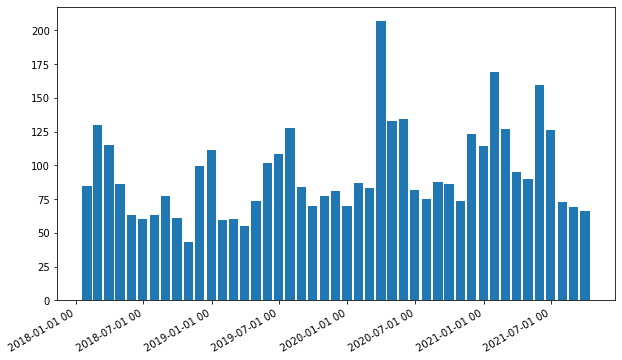

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
#ax.set_xticklabels(btc_hour['timestamp'], rotation=90)
ax.bar(btc_month['2018':].index, btc_month.loc['2018':, "Volume"], width=25, align='center')
fig.autofmt_xdate()

### Box Plot

One way to find seasonality is by using a set of boxplots. Here I am going to make boxplots for each hour. I will use ‘Open’, ‘Close’, ‘High’ and ‘Low’ data to make this plot.

The dataset is lack of the market between 2021-09-22 to 2022-01-01, we cut out the records between 2018-01-01 to 2018-09-20, to make sure every month has the same amount of data. 

In [ ]:
import time
mask = (btc['timestamp'] > '2018-09-21') & (btc['timestamp'] <= '2021-09-21')
btc_1821 = btc.loc[mask]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



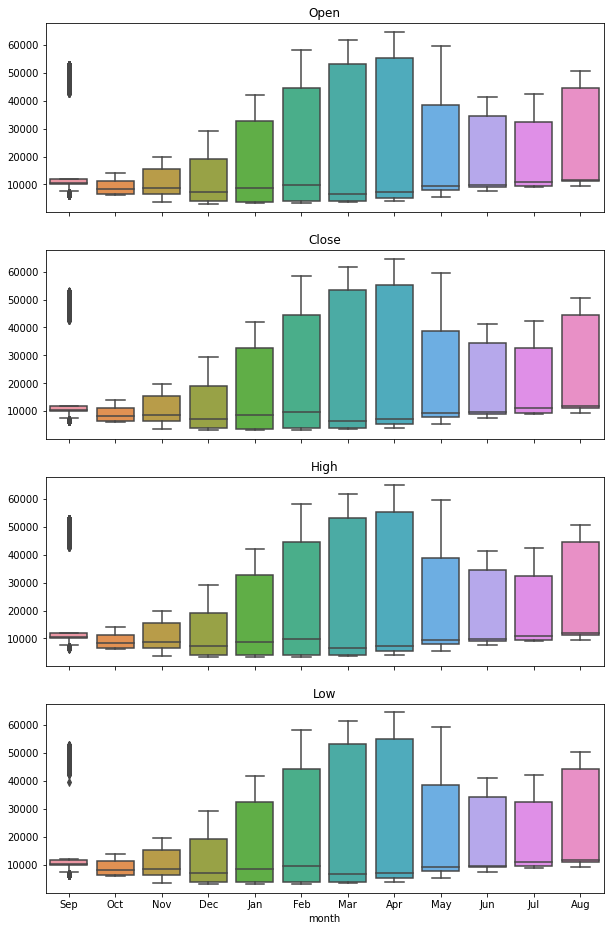

In [ ]:
import seaborn as sns
btc_1821['month'] = btc_1821['timestamp'].dt.strftime('%b')
#start, end = '2018-01-01 00', '2021-07-01 00'
fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)
for name, ax in zip(['Open', 'Close', 'High', 'Low'], axes):
    sns.boxplot(data=btc_1821,x='month', y=name, ax=ax)
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

**The box plots show that prices are usually at their low point in Sep, Oct, Nov, Dec, while at high point in Feb, Mar, Apr.**

‘Volume’ data was too busy in the original dataset. It can be fixed by resampling. Instead of plotting daily data, plotting monthly average will fix this issue to a large extent. I will use the btc_month dataset I prepared already for the bar plot and box plots above for this.

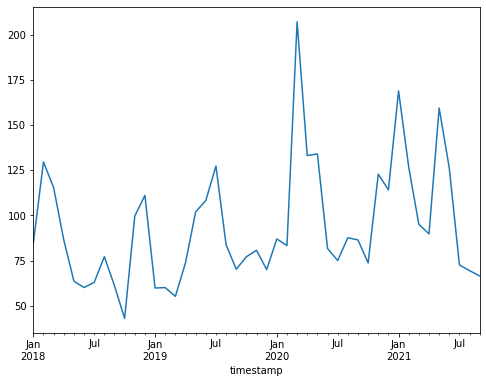

In [ ]:
btc_month['Volume'].plot(figsize=(8, 6))

In the ‘Volume’ data we are working on right now, we can observe some big spikes here and there. These types of spikes are not helpful for data analysis or for modeling. normally to smooth out the spikes, resampling to a lower frequency and rolling is very helpful.

In [ ]:
btc_week = btc_copy.resample("W", on='timestamp').mean()
btc_day = btc_copy.resample("D", on='timestamp').mean()

plot the daily and weekly data in the same plot.

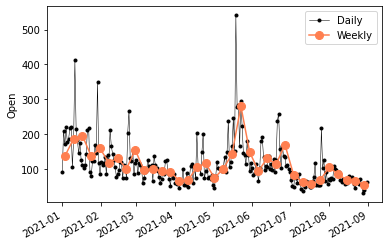

In [ ]:
start, end = '2021-01', '2021-08'
fig, ax = plt.subplots()
ax.plot(btc_day.loc[start:end, 'Volume'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(btc_week.loc[start:end, 'Volume'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
ax.set_ylabel("Open")
ax.legend()
fig.autofmt_xdate()

The weekly average plot has smaller spikes than daily data.

### ploting the change

In [9]:
btc_copy.head()

NameError: ignored

In [ ]:
btc_index = btc_copy.set_index("timestamp")

The shift function shifts the data before or after the specified amount of time. If I do not specify the time it will shift the data by one day by default. That means you will get the previous day's data. In financial data like this one, it is helpful to see previous day data and today's data side by side. It only plot the previous day data:

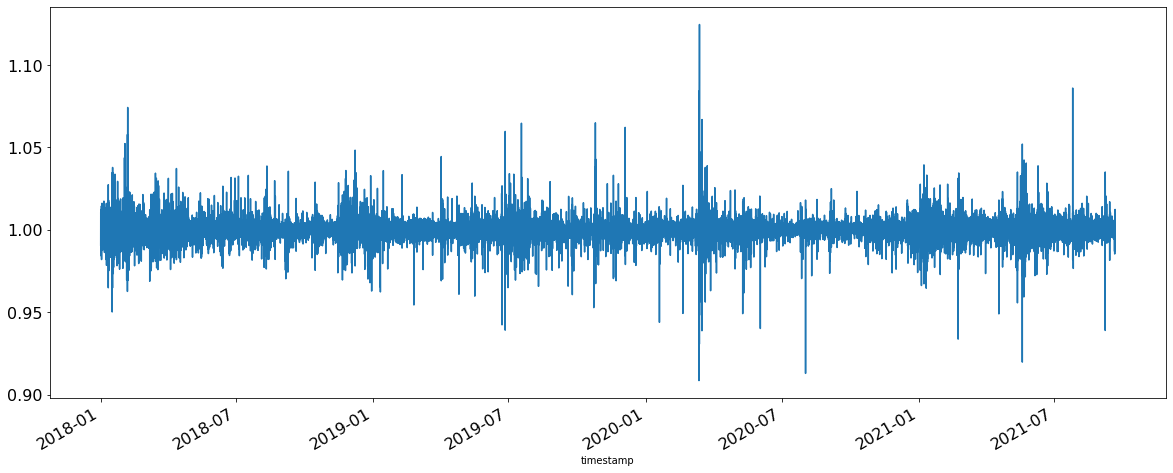

In [ ]:
btc_index['Change'] = btc_index.Close.div(btc_index.Close.shift())
btc_index['Change'].plot(figsize=(20, 8), fontsize = 16)

In the code above, .div() helps to fill up the missing data. Actually, div() means division. df. div(6) will divide each element in df by 6. But here I used ‘df.Close.shift()’. So, Each element of df will be divided by each element of ‘df.Close.shift()’. We do this to avoid the null values that are created by the ‘shift()’ operation

We can simply take a specific period and plot to have a clearer look. This is the plot of 2020 only.

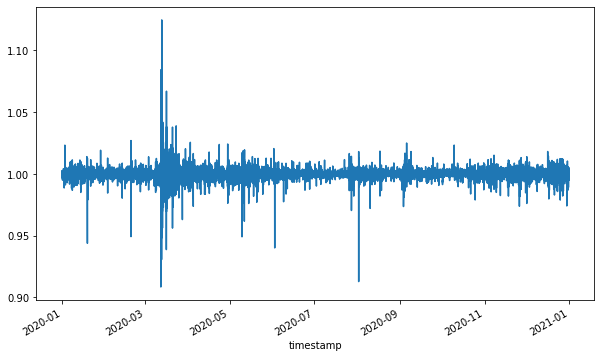

In [ ]:
btc_index['2020']['Change'].plot(figsize=(10, 6))

Another way of transformation. It keeps adding the cumulative. For example, if you add an expanding function to the ‘High’ column first element remains the same. The second element becomes cumulative of the first and second element, the third element becomes cumulative of the first, second, and third element, and so on. You can use aggregate functions like mean, median, standard deviation, etc. on it too.

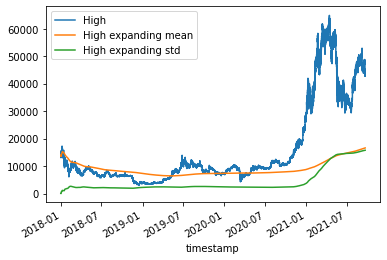

In [ ]:
fig, ax = plt.subplots()
ax = btc_index.High.plot(label='High')
ax = btc_index.High.expanding().mean().plot(label='High expanding mean')
ax = btc_index.High.expanding().std().plot(label='High expanding std')
ax.legend()

Decomposition will show the observations and these three elements in the same plot:
*   Trend: Consistent upward or downward slope of a time series.
*   Seasonality: Clear periodic pattern of a time series
*   Noise: Outliers or missing values

Original observations = Trend + Seasonality + Residuals




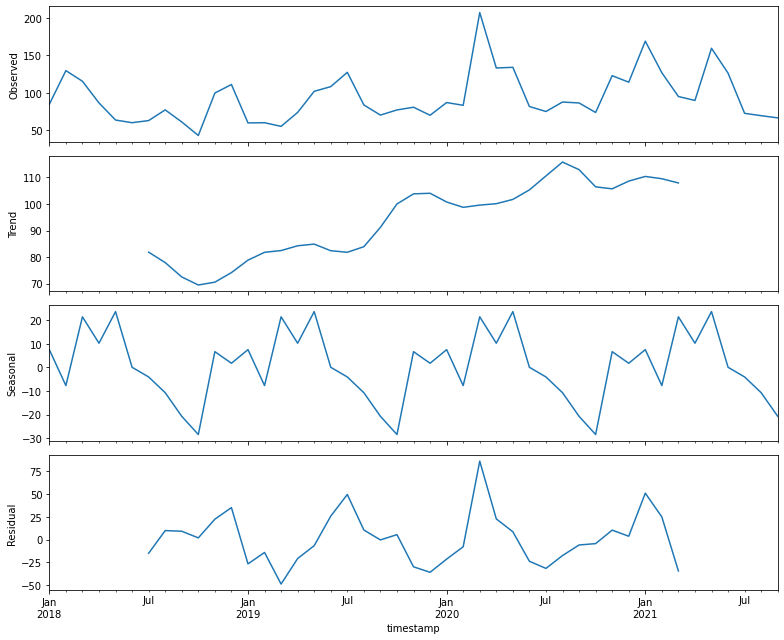

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(btc_month['Volume'], model='Additive')
fig = decomposition.plot()
plt.show()

## Correlation between assets

We hypothesized before that crypto asset returns may exhibit some correlation. Let's check this in more detail now.

We can check how the correlation between Bitcoin and Ethereum change over time for the 2021 period we selected. 

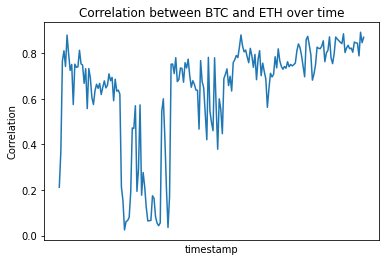

In [ ]:
# join two asset in single DataFrame

lret_btc_long = log_return(btc.Close)[1:]
lret_eth_long = log_return(eth.Close)[1:]
lret_btc_long.rename('lret_btc', inplace=True)
lret_eth_long.rename('lret_eth', inplace=True)
two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

# group consecutive rows and use .corr() for correlation between columns
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]

corr_time.plot();
plt.xticks([])
plt.ylabel("Correlation")
plt.title("Correlation between BTC and ETH over time");

Note the high but variable correlation between the assets. Here we can see that there is some changing dynamics over time, and this would be critical for this time series challenge, that is, how to perform forecasts in a highly non-stationary environment.

A stationary behaviour of a system or a process is characterized by non-changing statistical properties over time such as the mean, variance and autocorrelation. On the other hand, a non-stationary behaviour is characterized by a continuous change of statistical properties over time. Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

We can also check the correlation between all assets visualizing the correlation matrix. Note how some assets have much higher pairwise correlation than others.

In [ ]:
# create dataframe with returns for all assets
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = log_return(asset.Close.fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

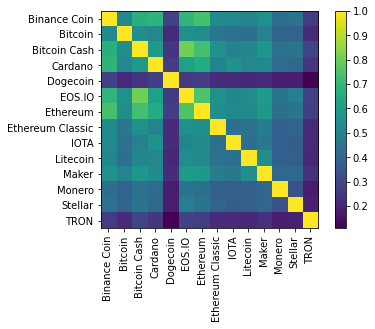

In [ ]:
plt.imshow(all_assets_2021.corr());
plt.yticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values);
plt.xticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

We encourage participants to perform additional statistical analyses to have a stronger grasp on the dataset, including autocorrelation, time-series decomposition and stationarity tests.

# Building your prediction model

This forecasting competition aims to predict returns in the near future for prices $P^a$, for each asset $a$. For each row in the dataset, we include the target for prediction, `Target`. `Target` is derived from log returns ($R^a$) over 15 minutes.

$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$

Crypto asset returns are highly correlated, following to a large extend the overall crypto market. As we want to test your ability to predict returns for individual assets, we perform a linear residualization, removing the market signal from individual asset returns when creating the target. In more detail, if $M(t)$ is the weighted average market returns, the target is:

$$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}  \\
\beta^a = \frac{\langle M \cdot R^a \rangle}{\langle M^2 \rangle} \\
\text{Target}^a(t) = R^a(t) - \beta^a M(t)$$

where the bracket $\langle .\rangle$ represent the rolling average over time (3750 minute windows), and same asset weights $w^a$ used for the evaluation metric.

Some rows have null values for targets due to missing values in future prices. Rows with nulls in the test set ground truth are ignored for scoring purposes.

In the competition, your predictions will be evaluated on a weighted version of the Pearson correlation coefficient, with weights given by the `Weight` column in the Asset Details file.

In this tutorial, we will simplify things and use correlation (without weights) for evaluation, and consider only two assets, BTC and ETH.

## Feature design

We first design a few relevant features to input to our model.

In [ ]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [ ]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_btc = pd.concat([log_return(btc.VWAP,periods=5), log_return(btc.VWAP,periods=1).abs(), 
               upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Target

X_eth = pd.concat([log_return(eth.VWAP,periods=5), log_return(eth.VWAP,periods=1).abs(), 
               upper_shadow(eth), lower_shadow(eth)], axis=1)
y_eth = eth.Target

## Preparing the data for building predictive models

As we will train linear regression parameters, we need to separate training and test sets. To do so, we will compute X and y and split this data into train and test splits. Note that the test split represents a later part of the data, as it is commonly done in time series. 

In [ ]:
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

We now standardize the input data. Standardization is the process of putting different variables on the same scale. In regression analysis, it is often crucial to standardize your independent variables or you may risk obtaining misleading results.

In [ ]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

## Baseline model: Linear Regression

We will try a simple Linear Regression model on the features we designed. Note that Linear Regression is not commonly used in time series analysis, specially with only one time step! 

We compare two Linear Regression baselines, one that considers each asset independently and one multiple inputs that models all assets together. 

In [ ]:
from sklearn.linear_model import LinearRegression

# implement basic ML baseline (one per asset)
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

In [ ]:
# implement more complex baseline (multiple output regression model)
from sklearn.multioutput import MultiOutputRegressor

# we concatenate X and y for both assets
X_both_train = np.concatenate((X_btc_train_scaled, X_eth_train_scaled), axis=1)
X_both_test = np.concatenate((X_btc_test_scaled, X_eth_test_scaled), axis=1)
y_both_train = np.column_stack((y_btc_train, y_eth_train))
y_both_test = np.column_stack((y_btc_test, y_eth_test))

# define the direct multioutput model and fit it
mlr = MultiOutputRegressor(LinearRegression())
lr.fit(X_both_train,y_both_train)
y_pred_lr_both = lr.predict(X_both_test)

## Evaluate baselines

The competition performance metric is weighted correlation. However, for now we will use simple correlation to evaluate the two baseline models built.

In [ ]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]:.2f}", 
                                ', ETH', f"{np.corrcoef(y_pred_lr_eth, y_eth_test)[0,1]:.2f}")
print('Test score for multiple output LR baseline: BTC', f"{np.corrcoef(y_pred_lr_both[:,0], y_btc_test)[0,1]:.2f}", 
                                                ', ETH', f"{np.corrcoef(y_pred_lr_both[:,1], y_eth_test)[0,1]:.2f}")

Test score for LR baseline: BTC -0.01 , ETH 0.02
Test score for multiple output LR baseline: BTC 0.01 , ETH 0.05


We can see that, for the training and test periods selected, the multiple asset LR model performs better than simply modelling each asset separately. Note that because the data is highly non-stationary, these results might vary a lot for different periods.

## GRU

In [ ]:
df_asset_details = asset_details.sort_values("Asset_ID")
df_train = crypto_df

In [ ]:
def hlco_ratio(df): return (df['High'] - df['Low'])/(df['Close']-df['Open'])
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
# It works for rows to, so we can reutilize it.
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    df_feat['hlco_ration'] = hlco_ratio(df_feat)
    return df_feat

In [ ]:
df = df_train[df_train["Asset_ID"] == 1]

df_proc = get_features(df)
df_proc['y'] = df['Target']
df_proc = df_proc.dropna(how="any")

X = df_proc.drop("y", axis=1)
y = df_proc["y"]

In [ ]:
df_proc.head()

,Count,Open,High,Low,Close,Volume,VWAP,Upper_Shadow,Lower_Shadow,hlco_ration,y
2,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,163.624,169.084,23.207182,-0.014643
10,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,217.264,148.102,-53.691953,-0.015037
18,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,176.500,200.314,-17.683521,-0.010309
26,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,196.488,191.760,-12.262706,-0.008999
34,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,189.900,170.474,-9.771212,-0.008079


In [ ]:
def get_Xy_and_model_for_asset(df_train, asset_id):
    df = df_train[df_train["Asset_ID"] == asset_id]
    
    df_proc = get_features(df)
    df_proc['y'] = df['Target']
    df_proc = df_proc.dropna(how="any")
    
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]
    gru = tf.keras.layers.GRU(4, return_sequences=True, return_state=True)
    whole_sequence_output, final_state = gru(inputs)    
    model = gru(device = 'gpu')
    model.fit(X, y)
    return X, y, model

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer=’adam’,loss=’mse’)
    return model
model_gru = create_gru(64)

In [ ]:
Xs = {}
ys = {}
models = {}

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    try:
        X, y, model = get_Xy_and_model_for_asset(df_train, asset_id)    
        Xs[asset_id], ys[asset_id], models[asset_id] = X, y, model
    except:         
        Xs[asset_id], ys[asset_id], models[asset_id] = None, None, None

In [ ]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,41761):
    X_train.append(X_btc_train_scaled[i-60:i,:])
    y_train.append(y_btc_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X.iloc[1,:]

Count             235.000000
Open            13835.036000
High            14052.300000
Low             13680.000000
Close           13828.102000
Volume             31.046432
VWAP            13840.362591
Upper_Shadow      217.264000
Lower_Shadow      148.102000
hlco_ration       -53.691953
Name: 10, dtype: float64

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,1955934):
    X_train.append(X.iloc[i-60:i,0:9])
    y_train.append(y.iloc[i])
X_train, y_train = np.array(X_train), np.array(y_train)

KeyboardInterrupt: ignored

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],4))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],4), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],4), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],4), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=3,batch_size=150)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
279/279 [==============================] - 80s 258ms/step - loss: 0.0011
Epoch 2/3
279/279 [==============================] - 77s 278ms/step - loss: 6.0707e-04
Epoch 3/3
279/279 [==============================] - 72s 259ms/step - loss: 4.4799e-04


In [ ]:
regressorGRU.save('/content/drive/MyDrive/competitions/g-research-crypto-forecasting')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/competitions/g-research-crypto-forecasting/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/competitions/g-research-crypto-forecasting/assets


In [ ]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

In [ ]:
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

In [ ]:
X_btc.head()

,VWAP,VWAP,0,1
timestamp,,,,
1514764860,NaN,NaN,163.624,169.084
1514764920,NaN,0.000961,217.264,148.102
1514764980,NaN,0.002481,176.500,200.314
1514765040,NaN,0.001629,196.488,191.760
1514765100,NaN,0.003489,189.900,170.474


In [ ]:
dataset_total=y_btc
test_set = y_btc_test
#test_set = y_btc.loc[test_window[0]:test_window[1]].fillna(0).values

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
#X_btc_train_scaled = scaler.fit_transform(X_btc.loc[train_window[0]:train_window[1]].fillna(0))

inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.fit_transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,41821):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],4))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = scaler.inverse_transform(GRU_predicted_stock_price)

ValueError: ignored

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real BTC Price')
    plt.plot(predicted, color='blue',label='Predicted BTC Price')
    plt.title('BTC Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('BTC Price')
    plt.legend()
    plt.show()

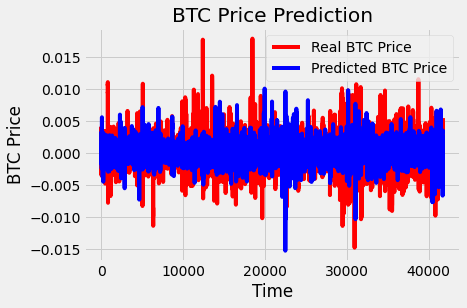

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
GRU_predicted_stock_price

array([[ 1.0996747e-04],
       [-1.0821195e-04],
       [ 7.5656048e-05],
       ...,
       [           nan],
       [           nan],
       [           nan]], dtype=float32)

In [ ]:
test_set

array([ 0.0017499 ,  0.00179512, -0.00120474, ...,  0.004956  ,
        0.00509619,  0.00544599])

## RNNs

In [10]:
from datetime import datetime
btc = crypto_df[crypto_df["Asset_ID"]==1]
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
btc_copy = btc
btc_copy['timestamp'] = pd.to_datetime(btc_copy['timestamp'], unit='s')

In [11]:
btc_copy.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,lower_shadow,high2low,volume2count
2,2018-01-01 00:01:00,1,229.0,13835.194,14013.80,13666.11,13850.176,31.550062,13827.062093,-0.014643,163.624,169.084,169.084,1.025442,0.137174
62,2018-01-01 00:08:00,1,437.0,13669.246,13914.60,13504.99,13721.348,78.298555,13701.600413,-0.008492,193.252,164.256,164.256,1.030330,0.178764
122,2018-01-01 00:16:00,1,392.0,13620.185,13702.71,13450.39,13604.025,55.076481,13607.979813,0.003169,82.525,153.635,153.635,1.018759,0.140144
182,2018-01-01 00:24:00,1,286.0,13599.362,13747.00,13412.05,13603.748,61.317263,13598.492585,0.000403,143.252,187.312,187.312,1.024974,0.213649
242,2018-01-01 00:31:00,1,348.0,13640.674,13764.80,13480.01,13658.372,44.435508,13645.840385,0.000873,106.428,160.664,160.664,1.021127,0.127322


In [12]:
btc_copy.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,lower_shadow,high2low,volume2count
24236582,2021-09-20 23:44:00,1,2165.0,42703.802500,42752.00,42636.76,42657.202500,86.518794,42680.263993,0.002726,48.197500,20.442500,20.442500,1.002703,0.039944
24236642,2021-09-20 23:49:00,1,3717.0,42745.153750,42937.31,42713.48,42898.565000,116.567006,42828.789861,NaN,38.745000,31.673750,31.673750,1.005240,0.031352
24236702,2021-09-20 23:53:00,1,1697.0,42974.108693,43005.65,42929.74,42960.601429,58.419459,42963.080444,NaN,31.541307,30.861429,30.861429,1.001768,0.034405
24236762,2021-09-20 23:57:00,1,2026.0,42904.197143,42932.00,42840.16,42860.005714,80.993326,42879.576084,NaN,27.802857,19.845714,19.845714,1.002144,0.039957
24236822,2021-09-21 00:00:00,1,2698.0,43009.961250,43048.51,42961.64,43002.505000,128.206820,43011.414052,NaN,38.548750,40.865000,40.865000,1.002022,0.047502


In [13]:
data_training = btc_copy[btc_copy['timestamp']< '2021-04-01'].copy()
data_training

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,lower_shadow,high2low,volume2count
2,2018-01-01 00:01:00,1,229.0,13835.194000,14013.80,13666.11,13850.176000,31.550062,13827.062093,-0.014643,163.624000,169.084000,169.084000,1.025442,0.137174
62,2018-01-01 00:08:00,1,437.0,13669.246000,13914.60,13504.99,13721.348000,78.298555,13701.600413,-0.008492,193.252000,164.256000,164.256000,1.030330,0.178764
122,2018-01-01 00:16:00,1,392.0,13620.185000,13702.71,13450.39,13604.025000,55.076481,13607.979813,0.003169,82.525000,153.635000,153.635000,1.018759,0.140144
182,2018-01-01 00:24:00,1,286.0,13599.362000,13747.00,13412.05,13603.748000,61.317263,13598.492585,0.000403,143.252000,187.312000,187.312000,1.024974,0.213649
242,2018-01-01 00:31:00,1,348.0,13640.674000,13764.80,13480.01,13658.372000,44.435508,13645.840385,0.000873,106.428000,160.664000,160.664000,1.021127,0.127322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20749862,2021-03-31 23:40:00,1,1514.0,58764.841429,58805.52,58729.26,58758.292857,31.851345,58769.698367,-0.000737,40.678571,29.032857,29.032857,1.001299,0.021024
20749922,2021-03-31 23:44:00,1,1370.0,58804.600000,58833.70,58767.73,58807.304286,27.433020,58800.022839,-0.002844,26.395714,36.870000,36.870000,1.001123,0.020009
20749982,2021-03-31 23:48:00,1,1265.0,58847.192857,58883.77,58823.10,58856.087673,21.012162,58848.985205,-0.001278,27.682327,24.092857,24.092857,1.001031,0.016597
20750042,2021-03-31 23:53:00,1,1803.0,58727.634286,58783.21,58693.00,58728.571429,35.690640,58736.265100,0.001303,54.638571,34.634286,34.634286,1.001537,0.019784


In [14]:
data_test = btc_copy[btc_copy['timestamp']> '2021-04-01'].copy()
data_test

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,lower_shadow,high2low,volume2count
20750162,2021-04-01 00:02:00,1,5493.0,58836.044286,58988.20,58807.58,58958.025714,164.061217,58910.188979,0.001832,30.174286,28.464286,28.464286,1.003071,0.029862
20750222,2021-04-01 00:06:00,1,2496.0,59010.056807,59108.35,58985.46,59072.957143,55.234011,59053.987896,-0.000626,35.392857,24.596807,24.596807,1.002083,0.022120
20750282,2021-04-01 00:11:00,1,1720.0,59067.675823,59100.49,59032.80,59054.880000,34.907641,59062.748232,-0.002975,32.814177,22.080000,22.080000,1.001147,0.020283
20750342,2021-04-01 00:15:00,1,2285.0,58977.091429,58998.65,58907.76,58963.674286,39.139131,58959.456573,-0.002552,21.558571,55.914286,55.914286,1.001543,0.017121
20750402,2021-04-01 00:19:00,1,3572.0,59010.895000,59043.69,58852.94,58912.788750,150.467343,58954.793991,-0.001178,32.795000,59.848750,59.848750,1.003241,0.042112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24236582,2021-09-20 23:44:00,1,2165.0,42703.802500,42752.00,42636.76,42657.202500,86.518794,42680.263993,0.002726,48.197500,20.442500,20.442500,1.002703,0.039944
24236642,2021-09-20 23:49:00,1,3717.0,42745.153750,42937.31,42713.48,42898.565000,116.567006,42828.789861,NaN,38.745000,31.673750,31.673750,1.005240,0.031352
24236702,2021-09-20 23:53:00,1,1697.0,42974.108693,43005.65,42929.74,42960.601429,58.419459,42963.080444,NaN,31.541307,30.861429,30.861429,1.001768,0.034405
24236762,2021-09-20 23:57:00,1,2026.0,42904.197143,42932.00,42840.16,42860.005714,80.993326,42879.576084,NaN,27.802857,19.845714,19.845714,1.002144,0.039957


In [15]:
btc_copy.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,lower_shadow,high2low,volume2count
count,403948.0,403948.000000,403948.000000,403948.000000,403948.000000,403948.000000,403948.000000,403948.000000,4.038720e+05,403948.000000,403948.000000,403948.000000,403948.000000,403948.000000
mean,1.0,1164.441332,16595.479901,16636.344073,16562.283316,16595.481984,94.726429,16595.355115,-1.697090e-07,35.209319,27.543814,27.543814,1.007667,0.109530
std,0.0,1693.949515,15780.925469,15792.481879,15764.739874,15780.961572,158.573439,15780.807178,2.013010e-03,45.909425,41.781423,41.781423,0.010872,0.086482
min,1.0,1.000000,3157.256548,3195.990000,3129.600000,3155.047143,0.000125,3156.154613,-5.362141e-02,0.000000,0.000000,0.000000,1.000000,0.000062
25%,1.0,319.000000,7020.193080,7035.099040,7008.008386,7020.248750,30.785283,7020.476783,-8.165293e-04,11.861429,9.638571,9.638571,1.002182,0.049222
50%,1.0,618.000000,9349.618571,9368.675000,9333.645000,9349.770714,53.888436,9349.578215,-2.162009e-05,22.042857,17.399456,17.399456,1.003475,0.085661
75%,1.0,1387.000000,18059.850981,18084.000000,18038.807500,18060.417143,99.494640,18059.869826,7.747117e-04,43.454071,32.581429,32.581429,1.006700,0.143804
max,1.0,87478.000000,64733.780000,64900.000000,64611.560000,64667.455714,7661.755743,64662.375964,7.971777e-02,6464.273750,8215.666250,8215.666250,1.500000,4.237936


In [16]:
training_data = data_training.drop(['timestamp', 'Asset_ID'], axis = 1)
training_data.head()

,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,lower_shadow,high2low,volume2count
2,229.0,13835.194,14013.80,13666.11,13850.176,31.550062,13827.062093,-0.014643,163.624,169.084,169.084,1.025442,0.137174
62,437.0,13669.246,13914.60,13504.99,13721.348,78.298555,13701.600413,-0.008492,193.252,164.256,164.256,1.030330,0.178764
122,392.0,13620.185,13702.71,13450.39,13604.025,55.076481,13607.979813,0.003169,82.525,153.635,153.635,1.018759,0.140144
182,286.0,13599.362,13747.00,13412.05,13603.748,61.317263,13598.492585,0.000403,143.252,187.312,187.312,1.024974,0.213649
242,348.0,13640.674,13764.80,13480.01,13658.372,44.435508,13645.840385,0.000873,106.428,160.664,160.664,1.021127,0.127322


In [17]:
training_data.tail()

,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,lower_shadow,high2low,volume2count
20749862,1514.0,58764.841429,58805.52,58729.26,58758.292857,31.851345,58769.698367,-0.000737,40.678571,29.032857,29.032857,1.001299,0.021024
20749922,1370.0,58804.600000,58833.70,58767.73,58807.304286,27.433020,58800.022839,-0.002844,26.395714,36.870000,36.870000,1.001123,0.020009
20749982,1265.0,58847.192857,58883.77,58823.10,58856.087673,21.012162,58848.985205,-0.001278,27.682327,24.092857,24.092857,1.001031,0.016597
20750042,1803.0,58727.634286,58783.21,58693.00,58728.571429,35.690640,58736.265100,0.001303,54.638571,34.634286,34.634286,1.001537,0.019784
20750102,1686.0,58693.772857,58774.84,58650.99,58738.320000,34.505284,58696.738587,0.001881,36.520000,42.782857,42.782857,1.002112,0.020454


In [ ]:
max(training_data['Volume'])

7661.755743305887

The first step we will take to our data is to normalize its values. The goal of normalization is to change the values of numeric columns in the data set to a common scale, without distorting differences in the ranges of values.

In [18]:
training_data.isna().sum()

Count            0
Open             0
High             0
Low              0
Close            0
Volume           0
VWAP             0
Target          72
Upper_Shadow     0
Lower_Shadow     0
lower_shadow     0
high2low         0
volume2count     0
dtype: int64

In [19]:
training_data.fillna(0.000001,inplace=True)

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[0.00440095, 0.18232375, 0.18453776, ..., 0.0288712 , 0.05088354,
        0.03235394],
       [0.00841585, 0.17949022, 0.18284553, ..., 0.02804681, 0.06066054,
        0.04216774],
       [0.00754724, 0.17865251, 0.17923097, ..., 0.02623327, 0.03751861,
        0.03305465],
       ...,
       [0.02439825, 0.95089504, 0.94996104, ..., 0.00411387, 0.0020628 ,
        0.00390172],
       [0.03478294, 0.9488536 , 0.94824562, ..., 0.00591383, 0.00307396,
        0.00465373],
       [0.03252456, 0.94827543, 0.94810283, ..., 0.0073052 , 0.00422329,
        0.0048117 ]])

In [26]:
X_train = [] 
Y_train = []
for i in range(60, training_data.shape[0]):
     X_train.append(training_data[i-60:i])
     Y_train.append(training_data[i,7])
X_train = np.delete(X_train, 7, axis=2)
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [27]:
X_train.shape

(345776, 60, 12)

### LSTM

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [28]:
def model_training(X,y):
    # Model training
    
    model = Sequential() 
    model.add(LSTM(units = 50, recurrent_activation = 'sigmoid', activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 12)))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 60, recurrent_activation = 'sigmoid', activation='tanh', return_sequences = True))
    model.add(Dropout(0.3)) 
    model.add(LSTM(units = 80, recurrent_activation = 'sigmoid', activation='tanh', return_sequences = True))
    model.add(Dropout(0.4)) 
    model.add(LSTM(units = 120, recurrent_activation = 'sigmoid',activation='tanh'))
    model.add(Dropout(0.5)) 
    model.add(Dense(units =1))
    model.fit(X, y)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(X, y, epochs = 3, batch_size =128, validation_split=0.1)
    return model

In [ ]:
%%time
Xs = {}
ys = {}
models = {}

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    X, y = get_data_for_asset(df_train, asset_id)    
    model = model_training(X,y)
    Xs[asset_id], ys[asset_id], models[asset_id] = X, y, model

Training model for Bitcoin Cash     (ID=2 )


NameError: ignored

Predict the price of cryptocurrency using LSTM neural network (deep learning)

This is the model-building stage. Finding the right model is an art, and it will take several tweaks and attempts to find the right layers and hyperparameters for each one.

The model building is quite simple and standard for this type of problem.

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [31]:
#Initialize the RNN
model = Sequential() 
model.add(LSTM(units = 50, recurrent_activation = 'sigmoid', activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 12)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, recurrent_activation = 'sigmoid', activation='tanh', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, recurrent_activation = 'sigmoid', activation='tanh', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, recurrent_activation = 'sigmoid',activation='tanh'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            12600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [32]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(training_data)))

False
False


In [33]:
history= model.fit(X_train, Y_train, epochs = 3, batch_size =128, validation_split=0.1)

Epoch 1/3
2432/2432 [==============================] - 199s 78ms/step - loss: 0.0011 - val_loss: 5.7874e-04
Epoch 2/3
2432/2432 [==============================] - 187s 77ms/step - loss: 2.1256e-04 - val_loss: 5.7844e-04
Epoch 3/3
2432/2432 [==============================] - 186s 77ms/step - loss: 1.9595e-04 - val_loss: 5.7636e-04


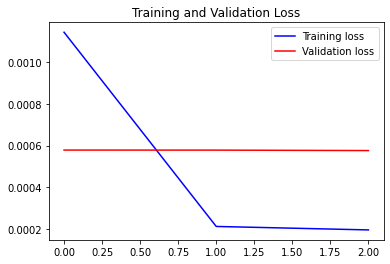

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [36]:
part_60_days = data_training.tail(60)
df= part_60_days.append(data_test, ignore_index = True)
df = df.drop(['timestamp', 'Asset_ID'], axis = 1)
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,lower_shadow,high2low,volume2count
0,2459.0,59030.728571,59106.00,59006.77,59078.387143,59.850005,59063.711160,-0.005992,27.612857,23.958571,23.958571,1.001682,0.024329
1,2258.0,59154.370000,59182.11,59099.94,59133.055714,89.268826,59142.232034,-0.004093,27.740000,33.115714,33.115714,1.001390,0.039517
2,2306.0,59034.715787,59079.92,58994.16,59044.477029,104.272245,59037.702805,-0.005699,35.442971,40.555787,40.555787,1.001454,0.045198
3,2923.0,58992.680000,59049.59,58889.66,58915.098571,103.788922,58968.341059,-0.006081,56.910000,25.438571,25.438571,1.002716,0.035496
4,7582.0,58431.380000,58576.10,58328.13,58512.275000,317.640320,58455.854436,-0.003771,63.825000,103.250000,103.250000,1.004251,0.041888


In [37]:
inputs = scaler.transform(df) 
inputs

array([[0.04744533, 0.95402888, 0.95375199, ..., 0.00409094, 0.00336334,
        0.00572622],
       [0.04356554, 0.95614003, 0.95505033, ..., 0.00565453, 0.00278071,
        0.00931002],
       [0.04449206, 0.95409696, 0.9533071 , ..., 0.00692493, 0.00290741,
        0.01065061],
       ...,
       [0.03273689, 0.67986516, 0.67910098, ..., 0.00526961, 0.00353648,
        0.00810373],
       [0.03908738, 0.67867143, 0.67784461, ..., 0.00338867, 0.00428757,
        0.00941391],
       [0.0520586 , 0.68047733, 0.67983212, ..., 0.00697772, 0.00404407,
        0.01119414]])

In [38]:
X_test = []
Y_test = []
for i in range(60, inputs.shape[0]):
     X_test.append(inputs[i-60:i])
     Y_test.append(inputs[i,7])
X_test = np.delete(X_test, 7, axis=2)
X_test, Y_test = np.array(X_test), np.array(Y_test)
Y_pred = model.predict(X_test) 
scaler.scale_

array([1.93024109e-05, 1.70748093e-05, 1.70586983e-05, 1.70978488e-05,
       1.70708412e-05, 1.30518389e-04, 1.70755560e-05, 7.49967116e+00,
       1.54696419e-04, 1.70750625e-04, 1.70750625e-04, 2.00000000e+00,
       2.35967376e-01])

In [39]:
scale = 1/1.93024109e-05
Y_test = Y_test*scale 
Y_pred = Y_pred*scale
Y_pred

array([[20835.17 ],
       [20835.197],
       [20835.154],
       ...,
       [20831.02 ],
       [20831.053],
       [20831.21 ]], dtype=float32)

In [40]:
Y_test

array([21545.64376062, 20590.50278918, 19677.84873145, ...,
                  nan,            nan,            nan])

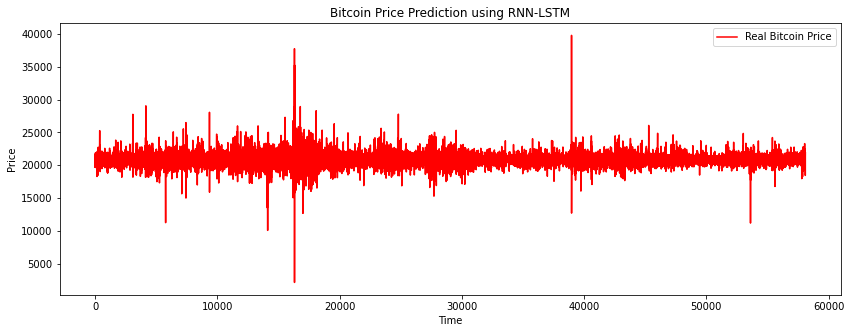

In [44]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
#plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## LGBM

In [2]:
import os
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor

#import gresearch_crypto

import warnings
warnings.filterwarnings("ignore")

In [3]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_all_seeds(42)

In [5]:
df_train = pd.read_csv('drive/MyDrive/competitions/g-research-crypto-forecasting/train.csv')
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [6]:
df_asset_details = pd.read_csv('/content/drive/MyDrive/competitions/g-research-crypto-forecasting/asset_details.csv')
df_asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [7]:
def get_features(data):
    # FE for data as row of DataFrame
    
    # Two new features from the competition tutorial
    df_feat = data[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['Upper_Shadow'] = df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open'])
    df_feat['Lower_Shadow'] = np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low']
    
    # Thanks to https://www.kaggle.com/code1110/gresearch-simple-lgb-starter
    df_feat['lower_shadow'] = np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low']
    df_feat['high2low'] = df_feat['High'] / df_feat['Low']
    df_feat['volume2count'] = df_feat['Volume'] / (df_feat['Count'] + 1)
    
    return df_feat

In [8]:
def get_data_for_asset(df_train, asset_id):
    # Get X and y
    
    df = df_train[df_train["Asset_ID"] == asset_id]    
    df_proc = get_features(df)
    df_proc['y'] = df['Target']
    #df_proc = df_proc[~df_proc.isin([np.nan, np.inf, -np.inf]).any(1)].reset_index(drop=True)
    df_proc = df_proc.dropna(how="any")
    
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]
    
    return X, y

In [9]:
def model_training(X,y):
    # Model training
    
    model = LGBMRegressor(n_estimators=5000,num_leaves=700,learning_rate=0.1)
    model.fit(X, y)
    
    return model

In [ ]:
%%time
Xs = {}
ys = {}
models = {}

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    X, y = get_data_for_asset(df_train, asset_id)    
    model = model_training(X,y)
    Xs[asset_id], ys[asset_id], models[asset_id] = X, y, model

Training model for Bitcoin Cash     (ID=2 )
Training model for Binance Coin     (ID=0 )
Training model for Bitcoin          (ID=1 )
Training model for EOS.IO           (ID=5 )
Training model for Ethereum Classic (ID=7 )
Training model for Ethereum         (ID=6 )
Training model for Litecoin         (ID=9 )
Training model for Monero           (ID=11)
Training model for TRON             (ID=13)
Training model for Stellar          (ID=12)


In [1]:
# Check the model and it's possibility for the prediction 
print("Check the model and it's possibility for the prediction")
x = get_features(df_train.iloc[1])
y_pred = models[0].predict([x])
y_pred[0]

Check the model and it's possibility for the prediction


NameError: ignored

In [ ]:
# Prediction and submission
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for i, (df_test, df_pred) in enumerate(iter_test):
    for j, row in df_test.iterrows():
        
        try:
            model = models[row['Asset_ID']]
            x_test = get_features(row)
            y_pred = model.predict([x_test])[0]

            df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
        
        except:
            print(f'{i}-th iteration of the test dataset, {j}-th row - there was the exception, then set Target = 0')
            df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = 0
            
        # Print just one sample row to get a feeling of what it looks like        
        if i == 0 and j == 0:
            print('Example of the x_test data')
            display(x_test)

    # Display the first prediction dataframe
    if i == 0:
        print('Example of the prediction for test data')
        display(df_pred)
    df_pred['Target'] = df_pred['Target'].fillna(0)

    # Send submissions
    env.predict(df_pred)